<a href="https://colab.research.google.com/github/JeromeHoen/OC_P4-Anticipez_le_retard_de_vol_des_avions/blob/master/Notebook_P4_Analyse_exploratoire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Anticipez le retard de vol des avions : Exploration

##Import des fonctions et du DataFrame

In [1]:
# data management
import pandas as pd    
import numpy as np
import scipy
import pickle

# data viz
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

from plotly.offline import download_plotlyjs, plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline()

# google colab modules

from google.colab import files

def configure_plotly_browser_state():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))
  
    
# ML algortihms

# data preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scoring and cross-validation
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, KFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# dimension reduction 
from sklearn.decomposition import PCA

# binary value prediction
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

# regression
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier

# bayesian optimization
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

# performance
from functools import wraps
import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kwargs):
        t_start = time.time()
        result = f(*args, **kwargs)
        t_end = time.time()
        print(f"function {f.__name__} with args {args}, kwargs {kwargs} took {t_end - t_start: 0.4f} sec.")
        return result
    return wrap
    
# deep learning
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import backend as K
import tensorflow as tf
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.models import load_model
from sklearn.utils import resample

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.0.1-cp36-none-any.whl size=10032 sha256=545ce9dd4470bb1ea30b795bac2eee153cf422a5453292e7e661eedb0316b913
  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization


Using TensorFlow backend.


In [0]:
# custom functions

from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def full_print(*arg, columns=20, rows=60, colwidth=50):
    """Set pandas.option_context and display a DataFrame"""
    with pd.option_context('display.max_columns', columns,
                           'display.max_rows', rows,
                           'display.max_colwidth', colwidth):
        display(*arg)
        
def display_circles(pca, axis_ranks=[(0, 1)], labels=None, label_rotation=0, lims=None):
    pcs = pca.components_
    n_comp = pca.n_components_
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

def plot_dendrogram(X, **kwargs):
    """
    Authors: Mathew Kallada
    License: BSD 3 clause
    =========================================
    Plot Hierarachical Clustering Dendrogram 
    =========================================
    This example plots the corresponding dendrogram of a hierarchical clustering
    using AgglomerativeClustering and the dendrogram method available in scipy.
    """

    plt.figure(figsize=(10, 50))
    plt.title('Hierarchical Clustering Dendrogram')

    model = AgglomerativeClustering()
    model = model.fit(X)

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, orientation='left', **kwargs)
    
    plt.show()

def print_scores(y_true_test, y_pred_test,
                 y_true_train=None, y_pred_train=None, decimals=3):
    
    test_results = dict(
        RMSE = f"{np.sqrt(mean_squared_error(y_true_test, y_pred_test)):.{decimals}f}",
        R2 = f"{r2_score(y_true_test, y_pred_test):.{decimals}f}",
        MAE = f"{mean_absolute_error(y_true_test, y_pred_test):.{decimals}f}"
    )

    if y_true_train is not None and y_pred_train is not None:
        train_results = dict(
            RMSE = f"{np.sqrt(mean_squared_error(y_true_train, y_pred_train)):.{decimals}f}",
            R2 = f"{r2_score(y_true_train, y_pred_train):.{decimals}f}",
            MAE = f"{mean_absolute_error(y_true_train, y_pred_train):.{decimals}f}"
        )

    for score in test_results:
        if y_true_train is not None and y_pred_train is not None:
            print(f"{score}: train={train_results[score]}, test={test_results[score]}")
        else:
            print(f"{score}: {test_results[score]}")

def print_cv_scores(cv_results, train_scores=False, decimals=3):

    test_results = dict(
        RMSE = f"{np.sqrt(-np.mean(cv_results['test_neg_mean_squared_error'])):.{decimals}f}",
        R2 = f"{np.mean(cv_results['test_r2']):.{decimals}f}",
        MAE = f"{-np.mean(cv_results['test_neg_mean_absolute_error']):.{decimals}f}"
    )

    if train_scores:
        train_results = dict(
            RMSE = f"{np.sqrt(-np.mean(cv_results['train_neg_mean_squared_error'])):.{decimals}f}",
            R2 = f"{np.mean(cv_results['train_r2']):.{decimals}f}",
            MAE = f"{-np.mean(cv_results['train_neg_mean_absolute_error']):.{decimals}f}"
        )

    for score in test_results:
        if train_scores:
            print(f"{score}: train={train_results[score]}, test={test_results[score]}")
        else:
            print(f"{score}: {test_results[score]}")

def linked_cols_to_dict(df, key_col, val_col):
    """Retrieve the table linking key_col and val_col as a dictionnary so the
    val_col can be dropped.
    """
    
    if not len(key_col) == len(val_col):
        raise ValueError("Different length for key_col and val_col")

    if len(key_col) > 1:
        groups = []
        for i in range(len(key_col)):
            group = df.groupby(key_col[i], observed=True)[val_col[i]].agg(pd.Series.mode)
            group.index = group.index.get_level_values(0)
            groups.append(group)

        stacked_values = np.concatenate([group.values for group in groups])
        stacked_index = np.concatenate([group.index for group in groups])

        groups = pd.Series(stacked_values, index=stacked_index)
        groups = groups.loc[~groups.index.duplicated(keep='first')]

        return dict(groups)

    else:
        group = df.groupby(key_col[i], observed=True)[val_col[i]].agg(pd.Series.mode)
        group.index = group.index.get_level_values(0)
        group = group.loc[~group.index.duplicated(keep='first')]
        return dict(group)

In [3]:
!wget https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Anticipez+le+retard+de+vol+des+avions+-+109/Dataset+Projet+4.zip
!unzip Dataset+Projet+4.zip

--2019-09-10 09:08:17--  https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Anticipez+le+retard+de+vol+des+avions+-+109/Dataset+Projet+4.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.100.75
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.100.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279971689 (267M) [application/x-www-form-urlencoded]
Saving to: ‘Dataset+Projet+4.zip’

Dataset+Projet+4.zi 100%[===================>] 267.00M  30.7MB/s    in 9.5s    

2019-09-10 09:08:27 (28.2 MB/s) - ‘Dataset+Projet+4.zip’ saved [279971689/279971689]

Archive:  Dataset+Projet+4.zip
  inflating: 2016_01.csv             
  inflating: 2016_02.csv             
  inflating: 2016_03.csv             
  inflating: 2016_04.csv             
  inflating: 2016_05.csv             
  inflating: 2016_06.csv             
  inflating: 2016_07.csv             
  inflati

In [0]:
import glob, os
                
all_files = sorted(glob.glob(os.path.join(os.getcwd(), "2016_*.csv")))

dtypes = {    
    'YEAR': np.int64,
    'QUARTER': np.int64,
    'MONTH': np.int64,
    'DAY_OF_MONTH': np.int64,
    'DAY_OF_WEEK': np.int64,
    'FL_DATE': "category",
    'UNIQUE_CARRIER': "category",
    'AIRLINE_ID': np.int64,
    'CARRIER': "category",
    'TAIL_NUM': "category",
    'FL_NUM': np.int64,
    'ORIGIN_AIRPORT_ID': np.int64,
    'ORIGIN_AIRPORT_SEQ_ID': np.int64,
    'ORIGIN_CITY_MARKET_ID': np.int64,
    'ORIGIN': "category",
    'ORIGIN_CITY_NAME': "category",
    'ORIGIN_STATE_ABR': "category",
    'ORIGIN_STATE_FIPS': np.float64,
    'ORIGIN_STATE_NM': "category",
    'ORIGIN_WAC': np.int64,
    'DEST_AIRPORT_ID': np.int64,
    'DEST_AIRPORT_SEQ_ID': np.int64,
    'DEST_CITY_MARKET_ID': np.int64,
    'DEST': "category",
    'DEST_CITY_NAME': "category",
    'DEST_STATE_ABR': "category",
    'DEST_STATE_FIPS': np.float64,
    'DEST_STATE_NM': "category",
    'DEST_WAC': np.float64,
    'CRS_DEP_TIME': np.float64,
    'DEP_TIME': np.float64,
    'DEP_DELAY': np.float64,
    'DEP_DELAY_NEW': np.float64,
    'DEP_DEL15': np.float64,
    'DEP_DELAY_GROUP': np.float64,
    'DEP_TIME_BLK': "category",
    'TAXI_OUT': np.float64,
    'WHEELS_OFF': np.float64,
    'WHEELS_ON': np.float64,
    'TAXI_IN': np.float64,
    'CRS_ARR_TIME': np.float64,
    'ARR_TIME': np.float64,
    'ARR_DELAY': np.float64,
    'ARR_DELAY_NEW': np.float64,
    'ARR_DEL15': np.float64,
    'ARR_DELAY_GROUP': np.float64,
    'ARR_TIME_BLK': "category",
    'CANCELLED': np.float64,
    'CANCELLATION_CODE': "category",
    'DIVERTED': np.float64,
    'CRS_ELAPSED_TIME': np.float64,
    'ACTUAL_ELAPSED_TIME': np.float64,
    'AIR_TIME': np.float64,
    'FLIGHTS': np.float64,
    'DISTANCE': np.float64,
    'DISTANCE_GROUP': np.float64,
    'CARRIER_DELAY': np.float64,
    'WEATHER_DELAY': np.float64,
    'NAS_DELAY': np.float64,
    'SECURITY_DELAY': np.float64,
    'LATE_AIRCRAFT_DELAY': np.float64,
    'FIRST_DEP_TIME': np.float64,
    'TOTAL_ADD_GTIME': np.float64,
    'LONGEST_ADD_GTIME': np.float64,
}

In [5]:
df = pd.concat((pd.read_csv(f, error_bad_lines=False, parse_dates=['FL_DATE'],) for f in all_files), ignore_index=True)

# drop last column
last_col_name = df.columns[-1]
df.drop(columns=last_col_name, inplace=True)

# drop rows where FLIGHTS != 1 (corrupted)
df = df[df.FLIGHTS == 1].reset_index(drop=True)

# convert flight date and force dtype on columns
df.FL_DATE = pd.to_datetime(df.FL_DATE).dt.strftime('%Y-%m-%d')

for col, dtype in dtypes.items():
    df[col] = df[col].astype(dtype)

# get all different airports in the dataset
us_airports = list(set(list(df.DEST.unique()) + list(df.ORIGIN.unique())))
us_airports = sorted(us_airports)
df.ORIGIN.cat.set_categories(us_airports)
df.DEST.cat.set_categories(us_airports)

# retrieve city and state based on airport
airport_city = linked_cols_to_dict(df, 
                                   key_col=('ORIGIN', 'DEST'),
                                   val_col=('ORIGIN_CITY_NAME', 'DEST_CITY_NAME'))

airport_state = linked_cols_to_dict(df, 
                                    key_col=('ORIGIN', 'DEST'),
                                    val_col=('ORIGIN_STATE_ABR', 'DEST_STATE_ABR'))
   
# duplicate columns or not used    
df.drop(columns=[
    'QUARTER', 'DAY_OF_MONTH',  # not used
    'UNIQUE_CARRIER', 'AIRLINE_ID', # =CARRIER
    'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', # =ORIGIN
    'ORIGIN_STATE_FIPS', 'ORIGIN_STATE_NM', 'ORIGIN_WAC', # =ORIGIN_STATE_ABR
    'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', # =DEST
    'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_WAC', # =DEST_STATE_ABR
    'ORIGIN_CITY_NAME', 'DEST_CITY_NAME', # saved as dict
    'FIRST_DEP_TIME', 'TOTAL_ADD_GTIME', 'LONGEST_ADD_GTIME', # DIVERTED flights out of scope
    'WHEELS_OFF', 'WHEELS_ON', # not used
], inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DtypeWarning:

Columns (48) have mixed types. Specify dtype option on import or set low_memory=False.

b'Skipping line 121012: expected 65 fields, saw 75\n'
b'Skipping line 386249: expected 65 fields, saw 83\nSkipping line 388291: expected 65 fields, saw 78\nSkipping line 389371: expected 65 fields, saw 72\nSkipping line 389548: expected 65 fields, saw 81\n'
b'Skipping line 453858: expected 65 fields, saw 97\n'
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DtypeWarning:

Columns (0,1,3,4,10,11,13,19,20,21,22,30,36,41,48) have mixed types. Specify dtype option on import or set low_memory=False.



##Description du dataset

In [6]:
df.sample(5, random_state=0)

YEAR  MONTH  ...  SECURITY_DELAY LATE_AIRCRAFT_DELAY
1194089  2016      3  ...             NaN                 NaN
2876467  2016      7  ...             0.0                 0.0
3371861  2016      8  ...             NaN                 NaN
5523974  2016     12  ...             NaN                 NaN
4898022  2016     11  ...             NaN                 NaN

[5 rows x 41 columns]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5635973 entries, 0 to 5635972
Data columns (total 41 columns):
YEAR                   int64
MONTH                  int64
DAY_OF_WEEK            int64
FL_DATE                category
CARRIER                category
TAIL_NUM               category
FL_NUM                 int64
ORIGIN                 category
ORIGIN_STATE_ABR       category
DEST                   category
DEST_STATE_ABR         category
CRS_DEP_TIME           float64
DEP_TIME               float64
DEP_DELAY              float64
DEP_DELAY_NEW          float64
DEP_DEL15              float64
DEP_DELAY_GROUP        float64
DEP_TIME_BLK           category
TAXI_OUT               float64
TAXI_IN                float64
CRS_ARR_TIME           float64
ARR_TIME               float64
ARR_DELAY              float64
ARR_DELAY_NEW          float64
ARR_DEL15              float64
ARR_DELAY_GROUP        float64
ARR_TIME_BLK           category
CANCELLED              float64
CANCELLATION_CODE 

In [8]:
df.describe([.01, .1, .25, .5, .75, .9, .99], include='number')

YEAR         MONTH  ...  SECURITY_DELAY  LATE_AIRCRAFT_DELAY
count  5635973.0  5.635973e+06  ...   968440.000000        968440.000000
mean      2016.0  6.506789e+00  ...        0.085111            24.339327
std          0.0  3.416782e+00  ...        2.426291            45.941604
min       2016.0  1.000000e+00  ...        0.000000             0.000000
1%        2016.0  1.000000e+00  ...        0.000000             0.000000
10%       2016.0  2.000000e+00  ...        0.000000             0.000000
25%       2016.0  3.000000e+00  ...        0.000000             0.000000
50%       2016.0  7.000000e+00  ...        0.000000             2.000000
75%       2016.0  9.000000e+00  ...        0.000000            30.000000
90%       2016.0  1.100000e+01  ...        0.000000            73.000000
99%       2016.0  1.200000e+01  ...        0.000000           211.000000
max       2016.0  1.200000e+01  ...      474.000000          1484.000000

[12 rows x 31 columns]

In [0]:
sample_df = df.sample(100000, random_state=0)

##Déviation des variables catégorielles par rapport à la moyenne

###Mois

In [10]:
means = sample_df.drop(columns=['YEAR', 'MONTH']).mean(numeric_only=True)
monthly_means = sample_df.groupby(['YEAR', 'MONTH']).mean()
monthly_average_dev = (monthly_means - means) / means
monthly_average_dev

DAY_OF_WEEK    FL_NUM  ...  SECURITY_DELAY  LATE_AIRCRAFT_DELAY
YEAR MONTH                         ...                                     
2016 1         0.045173 -0.006417  ...       -0.537575            -0.053357
     2        -0.034331 -0.051729  ...        0.290358             0.098958
     3        -0.027042  0.030507  ...       -0.565533            -0.035021
     4         0.021377  0.042063  ...       -0.015754            -0.096330
     5        -0.020318  0.004264  ...       -0.416254            -0.109311
     6        -0.001492 -0.010984  ...        1.063861             0.040709
     7         0.054556  0.015824  ...       -0.068034             0.090061
     8        -0.043052 -0.016957  ...        1.915444             0.204764
     9         0.001204 -0.038506  ...       -0.379396            -0.162448
     10        0.019408 -0.049183  ...       -1.000000            -0.066829
     11       -0.020776  0.010312  ...       -0.711561            -0.273680
     12        0.017293  0.069846  ...       -0.591012             0.085987

[12 rows x 29 columns]

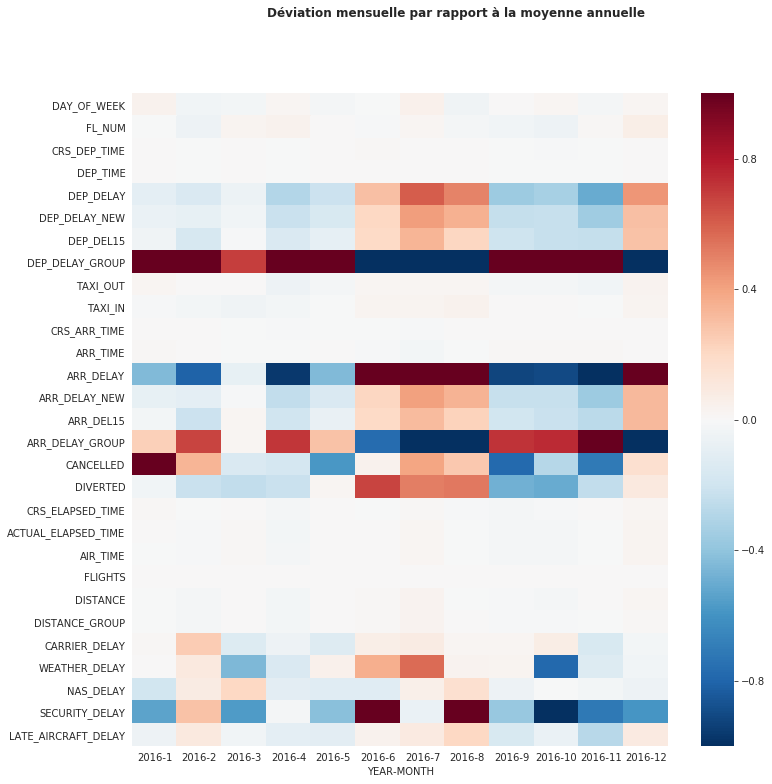

In [0]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(monthly_average_dev.transpose(), cmap='RdBu_r', vmin=-1, vmax=1, ax=ax)
plt.suptitle('Déviation mensuelle par rapport à la moyenne annuelle', weight='bold')
plt.show()

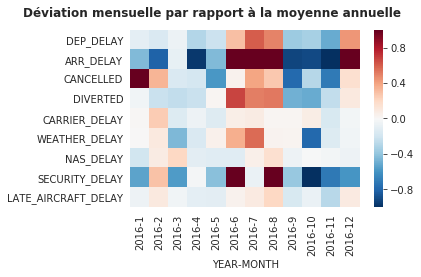

In [15]:
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(monthly_average_dev.transpose().loc[['DEP_DELAY', 'ARR_DELAY', 'CANCELLED', 'DIVERTED', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']], cmap='RdBu_r', vmin=-1, vmax=1, ax=ax)
plt.suptitle('Déviation mensuelle par rapport à la moyenne annuelle', weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Les délais à l'arrivée sont en moyenne plus élevés en juin-juillet-août.

###Jour de la semaine

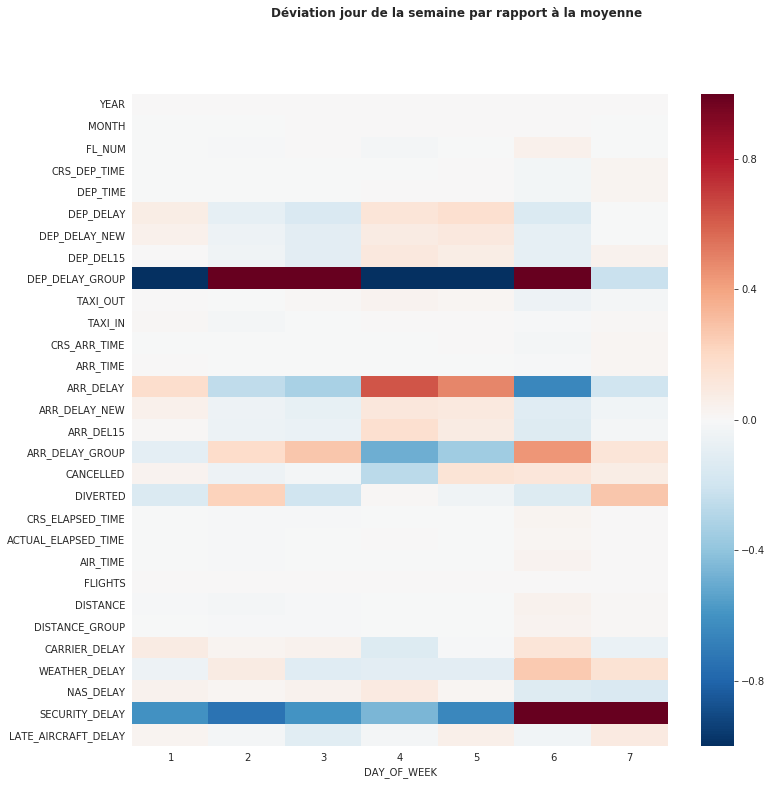

In [0]:
means = sample_df.drop(columns=['DAY_OF_WEEK']).mean(numeric_only=True)
dow_means = sample_df.groupby(['DAY_OF_WEEK']).mean()
dow_average_dev = (dow_means - means) / means

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(dow_average_dev.transpose(), cmap='RdBu_r', vmin=-1, vmax=1, ax=ax)
plt.suptitle('Déviation jour de la semaine par rapport à la moyenne', weight='bold')
plt.show()

Délais plus important le jeudi et le vendredi et plus faibles le week-end.

In [17]:
import holidays
us_holidays = holidays.US()

days = df.FL_DATE.unique()
holidays = [date for date in days if date in us_holidays]
print(f"nombre de jours dans la base: {len(days)}")
print(f"dont {len(holidays)} jours fériés")

nombre de jours dans la base: 366
dont 11 jours fériés


In [18]:
df['IS_HOLIDAY'] = 0
for holiday in holidays:
    df.loc[df[df.FL_DATE == holiday].index, 'IS_HOLIDAY'] = 1

print(f"Pourcentage de vols les jours fériés : {df['IS_HOLIDAY'].mean() * 100:.1f}%")

Pourcentage de vols les jours fériés : 2.8%


In [0]:
df['DAY_OF_WEEK_H'] = df['DAY_OF_WEEK'].astype(str)
df.loc[df[df['IS_HOLIDAY']==1].index, 'DAY_OF_WEEK_H'] = 'H'

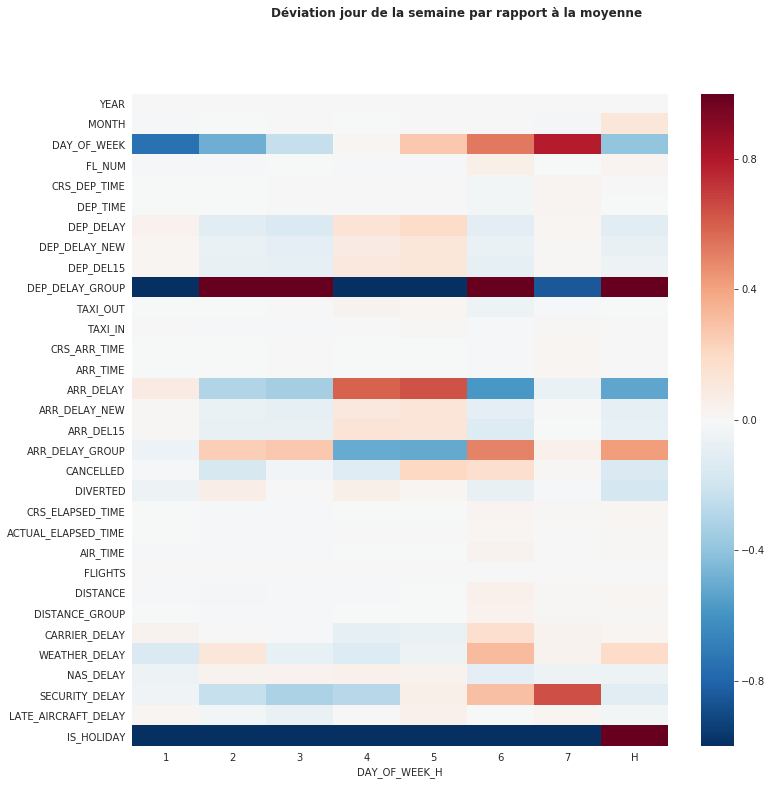

In [26]:
means = df.drop(columns=['DAY_OF_WEEK_H']).mean(numeric_only=True)
dowh_means = df.groupby(['DAY_OF_WEEK_H']).mean()
dowh_average_dev = (dowh_means - means) / means

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(dowh_average_dev.transpose(), cmap='RdBu_r', vmin=-1, vmax=1, ax=ax)
plt.suptitle('Déviation jour de la semaine par rapport à la moyenne', weight='bold')
plt.show()

Les jours fériés peuvent être considérés comme un jour de week-end. Les vols sont en moyenne moins souvent en retard.

###Heure de départ

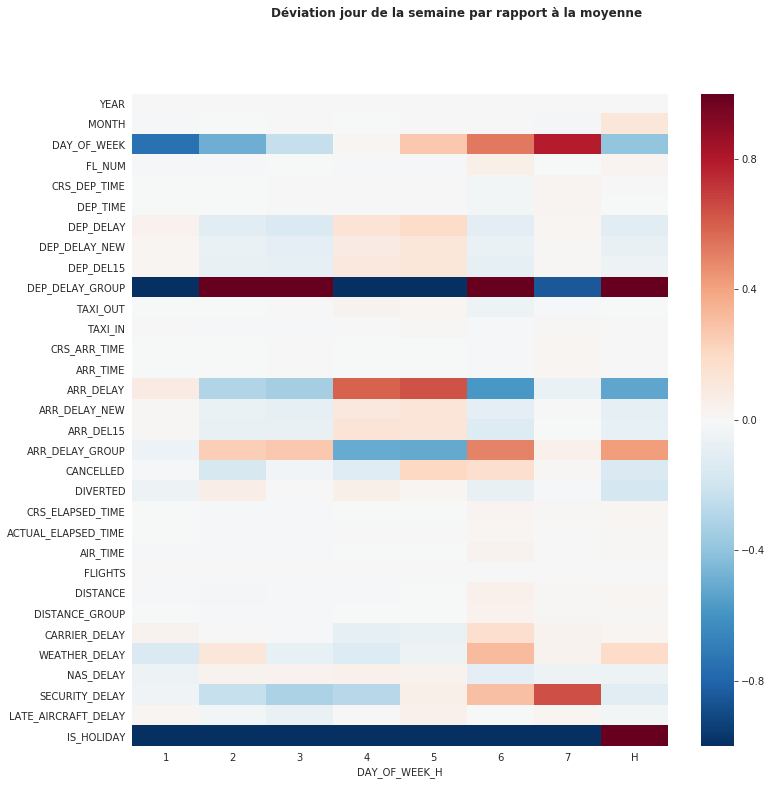

In [25]:
means = df.drop(columns=['DAY_OF_WEEK_H']).mean(numeric_only=True)
dowh_means = df.groupby(['DAY_OF_WEEK_H']).mean()
dowh_average_dev = (dowh_means - means) / means

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(dowh_average_dev.transpose(), cmap='RdBu_r', vmin=-1, vmax=1, ax=ax)
plt.suptitle('Déviation jour de la semaine par rapport à la moyenne', weight='bold')
plt.show()

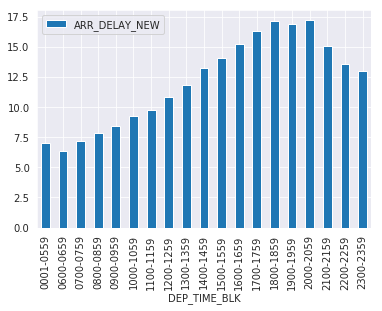

In [0]:
df[['DEP_TIME_BLK', 'ARR_DELAY_NEW']].groupby('DEP_TIME_BLK').mean().plot.bar()

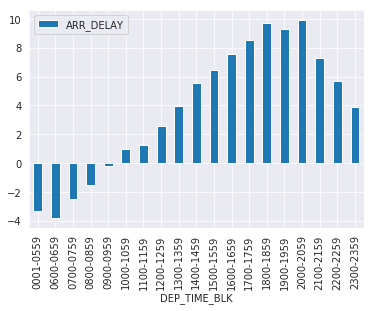

In [0]:
df[['DEP_TIME_BLK', 'ARR_DELAY']].groupby('DEP_TIME_BLK').mean().plot.bar()

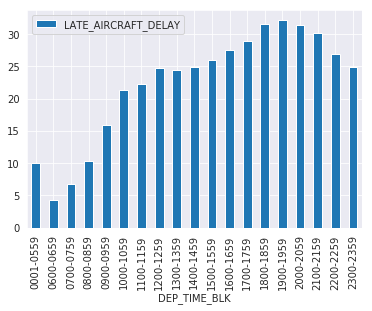

In [0]:
df[['DEP_TIME_BLK', 'LATE_AIRCRAFT_DELAY']].groupby('DEP_TIME_BLK').mean().plot.bar()

Les vols en fin d'apèrs-midi de début de soirée sont les plus sujets à des retards.

###Compagnie aérienne

In [0]:
df.CARRIER.value_counts()

WN    1296854
DL     970822
AA     886057
OO     604283
UA     545067
EV     503343
B6     284666
AS     166957
NK     138199
F9      95857
HA      76536
VX      67332
Name: CARRIER, dtype: int64

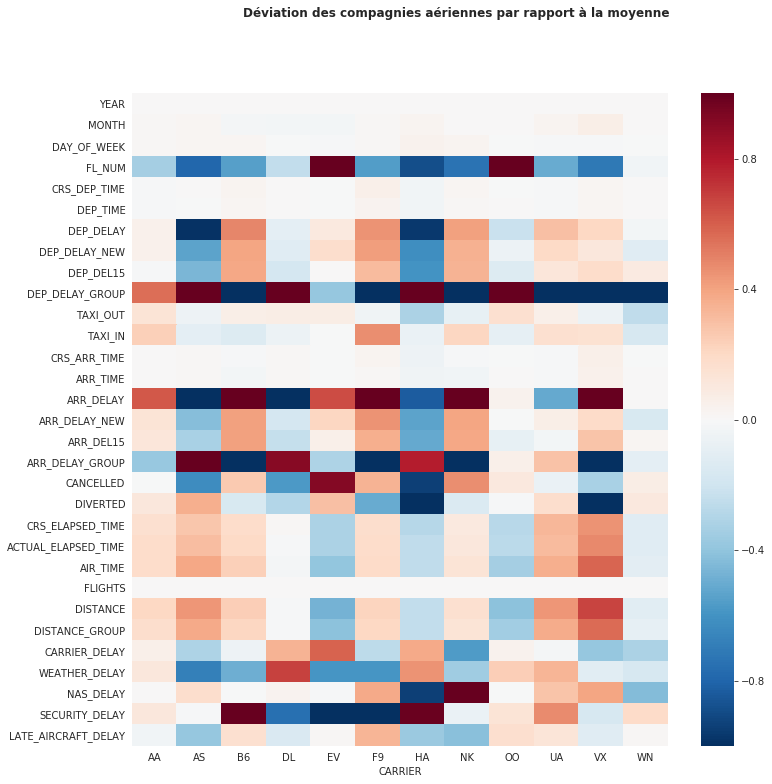

In [0]:
means = sample_df.drop(columns=['CARRIER']).mean(numeric_only=True)
airline_means = sample_df.groupby(['CARRIER']).mean()
airline_average_dev = (airline_means - means) / means

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(airline_average_dev.transpose(), cmap='RdBu_r', vmin=-1, vmax=1, ax=ax)
plt.suptitle('Déviation des compagnies aériennes par rapport à la moyenne', weight='bold')
plt.show()

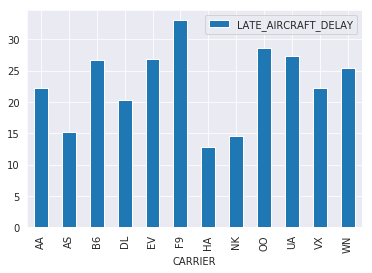

In [0]:
df[['CARRIER', 'LATE_AIRCRAFT_DELAY']].groupby('CARRIER').mean().plot.bar()

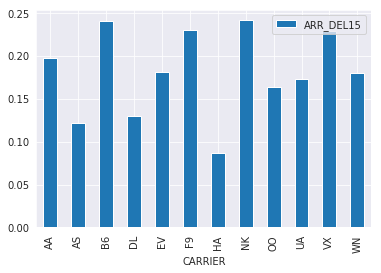

In [0]:
df[['CARRIER', 'ARR_DEL15']].groupby('CARRIER').mean().plot.bar()

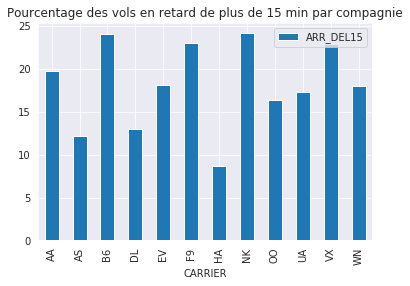

In [30]:
(df[['CARRIER', 'ARR_DEL15']].groupby('CARRIER').mean() * 100).plot.bar()
plt.title("Pourcentage des vols en retard de plus de 15 min par compagnie")
plt.show()

(-60, 100)

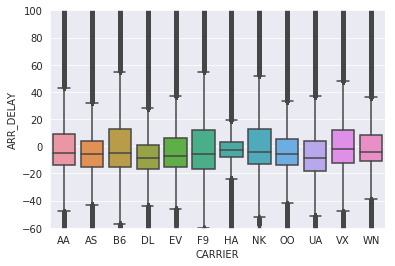

In [91]:
sns.boxplot(x='CARRIER', y='ARR_DELAY', data=df)
plt.ylim(top=100, bottom=-60)


Certaines compagnies aériennes sont moins souvent en retard que d'autres

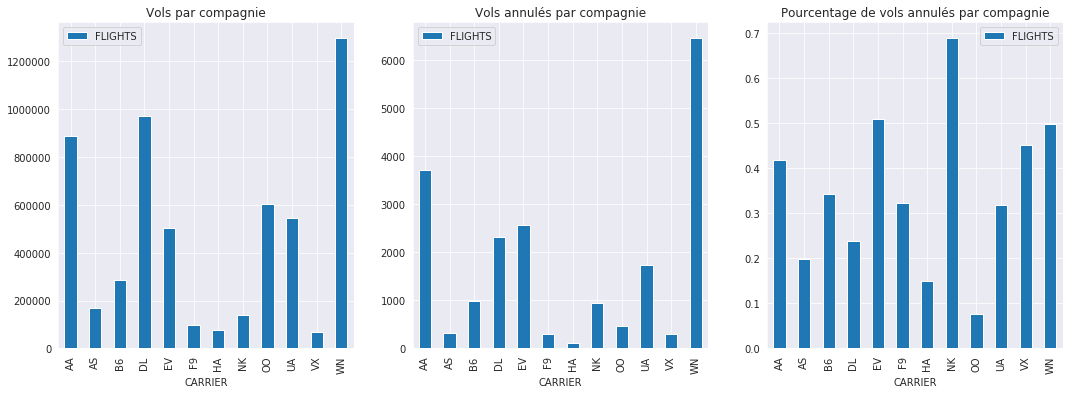

In [0]:
fig, ax = plt.subplots(1,3, figsize=(18,6))
df.loc[:,['CARRIER', 'FLIGHTS']].groupby('CARRIER').sum().plot(kind='bar', title='Vols par compagnie', ax=ax[0])
df.loc[df.CANCELLATION_CODE == "A", ['CARRIER', 'FLIGHTS']].groupby('CARRIER').sum().plot(kind='bar', title='Vols annulés par compagnie', ax=ax[1])
(100 * df.loc[df.CANCELLATION_CODE == "A", ['CARRIER', 'FLIGHTS']].groupby('CARRIER').sum() / df.loc[:,['CARRIER', 'FLIGHTS']].groupby('CARRIER').sum()).plot(kind='bar', title='Pourcentage de vols annulés par compagnie', ax=ax[2])

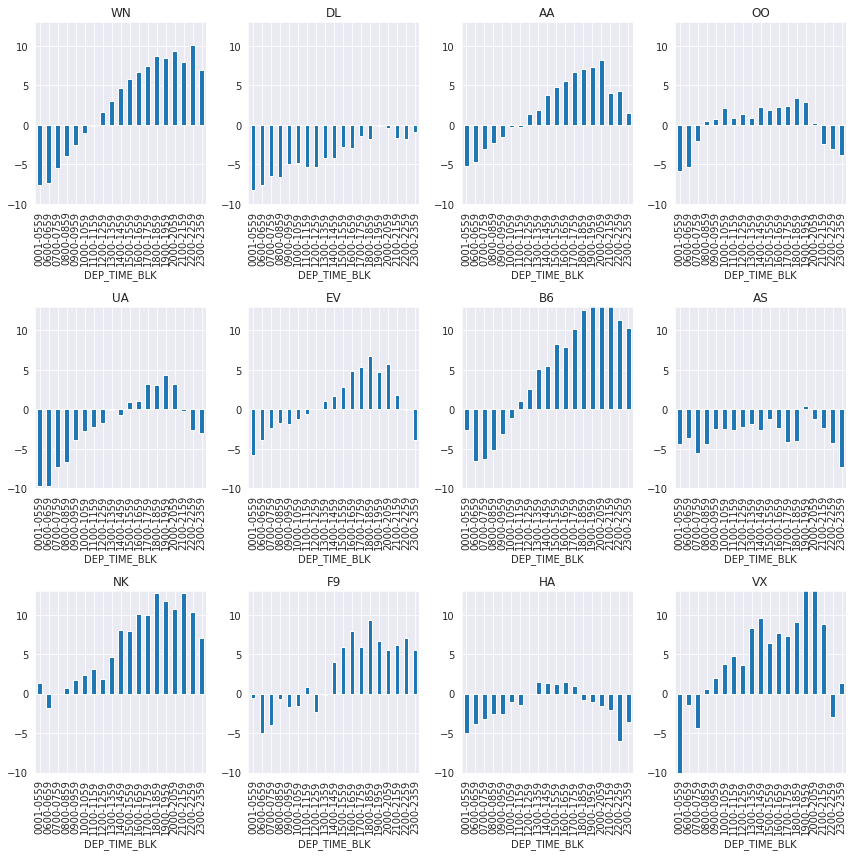

In [0]:
carriers = df['CARRIER'].value_counts().index

fig, ax = plt.subplots(3, 4, figsize=(12,12))

for i, carrier in enumerate(carriers):
    axe = ax.flat[i]
    df[df.CARRIER==carrier].groupby('DEP_TIME_BLK').ARR_DELAY.mean().plot(kind='bar', ax=axe)
    axe.set_title(f"{carrier}")
    axe.set_ylim([-10, 13])
   
plt.tight_layout()
plt.title("Retard moyen par compagnie et par heure")

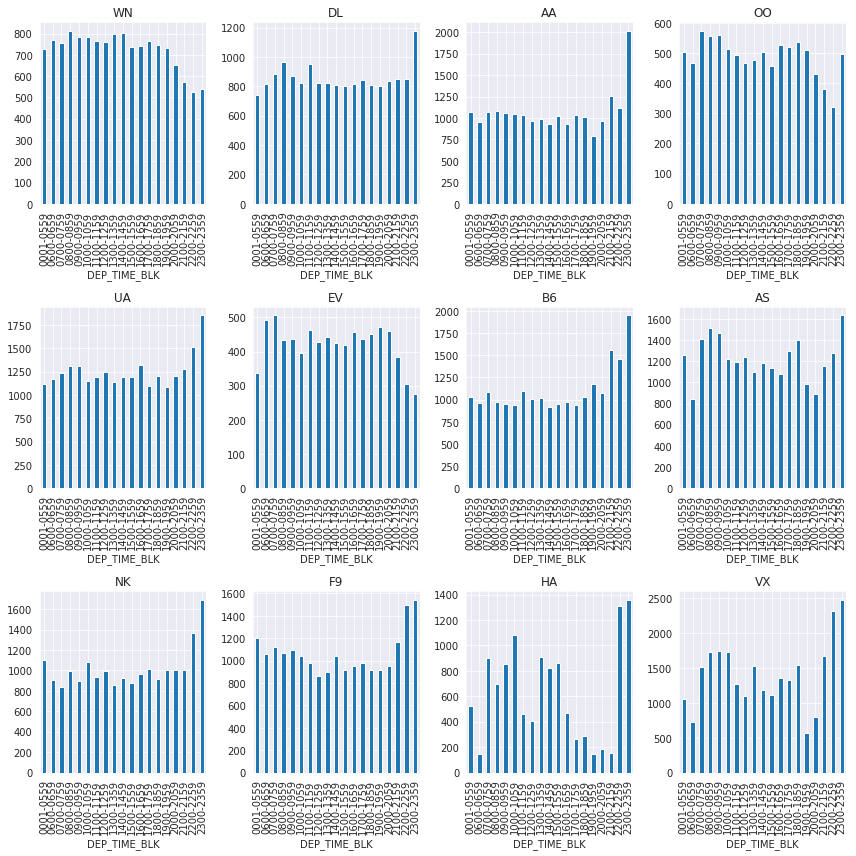

In [0]:
carriers = df['CARRIER'].value_counts().index

fig, ax = plt.subplots(3, 4, figsize=(12,12))

for i, carrier in enumerate(carriers):
    axe = ax.flat[i]
    df[df.CARRIER==carrier].groupby('DEP_TIME_BLK').DISTANCE.mean().plot(kind='bar', ax=axe)
    axe.set_title(f"{carrier}")
    
plt.tight_layout()
plt.title("Distance moyenne par compagnie et par heure")

##Analyse des aéroports

In [0]:
print(f"Nombre d'aéroports (départ): {df.ORIGIN.nunique()}")
print(f"Nombre d'aéroports (arrivée): {df.DEST.nunique()}")
print(f"Nombre de liaisons: {df[['ORIGIN', 'DEST', 'FLIGHTS']].groupby(['ORIGIN', 'DEST']).size().shape[0]}")

Nombre d'aéroports (départ): 313
Nombre d'aéroports (arrivée): 310
Nombre de liaisons: 4591


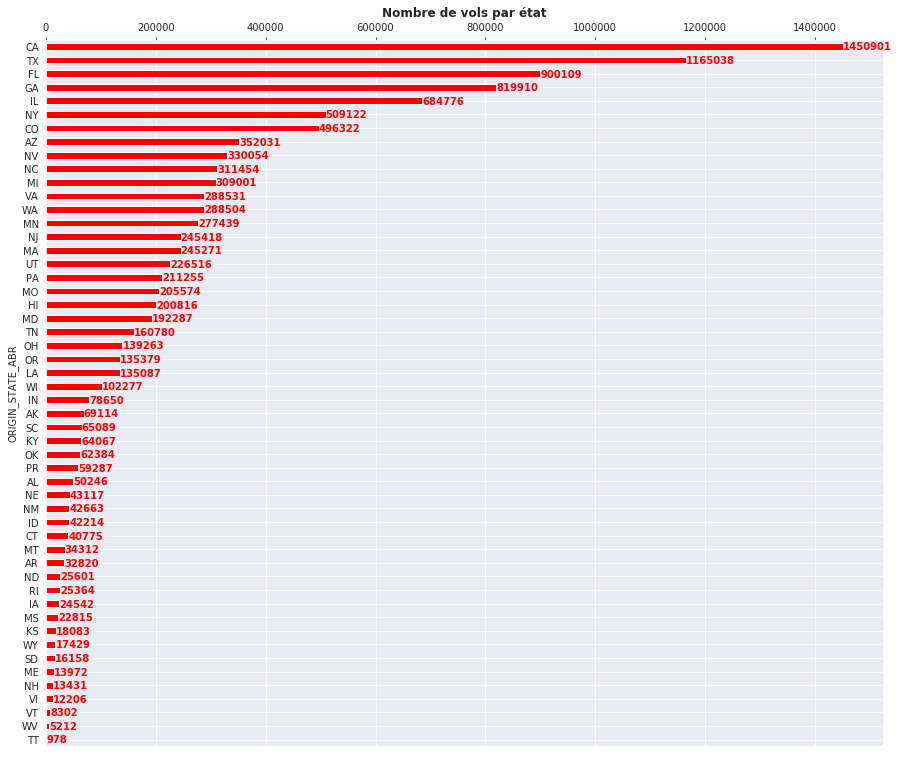

In [71]:
states = sorted(list(df['ORIGIN_STATE_ABR'].unique()))

incoming = df.groupby(['ORIGIN_STATE_ABR']).FLIGHTS.sum().astype(int)
outgoing = df.groupby(['DEST_STATE_ABR']).FLIGHTS.sum().astype(int)
total_flights = incoming + outgoing

total_flights = total_flights.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15,13))
total_flights.plot.barh(ax=ax, color='red')
plt.gca().invert_yaxis()
ax.set_title("Nombre de vols par état", fontweight='bold')
ax.xaxis.tick_top()
for i, v in enumerate(total_flights):
    ax.text(v + 3, i + .25, str(v), color='red', fontweight='bold')

In [64]:
# look only for the 7 biggest states
top_states = list(total_flights.index)[:7]

# get inter-states' connections
states_flights = df.groupby(['ORIGIN_STATE_ABR', 'DEST_STATE_ABR']).FLIGHTS.sum()
states_flights = states_flights.to_frame()

states_origin = np.array(states_flights.index.get_level_values(0))
states_dest = np.array(states_flights.index.get_level_values(1))

# filter for top 7 states and replace by 'other'
states_flights['NEW_ORIGIN'] = states_origin
states_flights['NEW_DEST'] = states_dest

states_flights.loc[~np.isin(states_origin, top_states), 'NEW_ORIGIN'] = 'other'
states_flights.loc[~np.isin(states_dest, top_states), 'NEW_DEST'] = 'other'

# if a flight is inside a state but is not in the top 7 states:
# flight is from 'other' to 'same state
criteria1 = states_flights['NEW_DEST']=='other'
criteria2 = states_origin == states_dest
states_flights.loc[criteria1 & criteria2, 'NEW_DEST'] = 'same state'

states_flights = states_flights.groupby(['NEW_ORIGIN', 'NEW_DEST']).FLIGHTS.sum()
states_flights.head()

NEW_ORIGIN  NEW_DEST
CA          CA          227213.0
            CO           38676.0
            FL           13855.0
            GA           15097.0
            IL           32143.0
Name: FLIGHTS, dtype: float64

###Sankey diagram

In [66]:
new_states_list = top_states + ['other', 'same state']
position_dict = {}

for i, state in enumerate(new_states_list):
    position_dict['from ' + state] = i * 2
    position_dict['to ' + state] = i * 2 + 1

label = sorted(position_dict, key=position_dict.get)
source = ('from ' + states_flights.index.get_level_values(0)).map(position_dict)
target = ('to ' + states_flights.index.get_level_values(1)).map(position_dict)

configure_plotly_browser_state()

data = dict(
    type='sankey',
    node = dict(
      pad = 10,
      thickness = 20,
      line = dict(
        color = "black",
        width = 1
      ),
      label = label,
      color = 'blue'
    ),
    link = dict(
      source = source,
      target = target,
      value = states_flights
  ))

layout =  dict(
    title = "Liaisions inter-Etats",
    font = dict(
      size = 10
    )
)

fig = dict(data=[data], layout=layout)
iplot(fig, validate=False)

###Création d'une visualisation dans Tableau

Visualisation uploadée [ici](https://public.tableau.com/profile/jerome.hoen#!/vizhome/Rpartitiondesdestinations/Feuille1)

In [67]:
airports = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat', header=None, index_col=0)
airports.head()

1   ...           13
0                                               ...             
1                               Goroka Airport  ...  OurAirports
2                               Madang Airport  ...  OurAirports
3                 Mount Hagen Kagamuga Airport  ...  OurAirports
4                               Nadzab Airport  ...  OurAirports
5  Port Moresby Jacksons International Airport  ...  OurAirports

[5 rows x 13 columns]

In [68]:
airports_coords = airports[airports.loc[:,4].isin(us_airports)].loc[:,[1,4,6,7,9,10,11]]
airports_coords.columns = ['AIRPORT', 'IATA', 'LATITUDE', 'LONGITUDE', 'TIMEZONE', 'DST', 'TZ_DATABASE']
airports_coords.reset_index(drop=True, inplace=True)
airports_coords.head()

AIRPORT IATA  ...  DST        TZ_DATABASE
0           Pago Pago International Airport  PPG  ...    U  Pacific/Pago_Pago
1              Saipan International Airport  SPN  ...    U     Pacific/Saipan
2  Antonio B. Won Pat International Airport  GUM  ...    U       Pacific/Guam
3                     Cyril E. King Airport  STT  ...    U  America/St_Thomas
4                   Henry E Rohlsen Airport  STX  ...    U  America/St_Thomas

[5 rows x 7 columns]

In [69]:
coords_flights = df[['ORIGIN', 'DEST', 'FL_DATE', 'FLIGHTS']]
coords_flights.head()

ORIGIN DEST     FL_DATE  FLIGHTS
0    DFW  DTW  2016-01-06      1.0
1    DFW  DTW  2016-01-07      1.0
2    DFW  DTW  2016-01-08      1.0
3    DFW  DTW  2016-01-09      1.0
4    DFW  DTW  2016-01-10      1.0

In [0]:
iata_latitude = dict(airports_coords[['IATA', 'LATITUDE']].values)
iata_longitude = dict(airports_coords[['IATA', 'LONGITUDE']].values)

In [0]:
coords_flights['ORIGIN_LAT'] = coords_flights['ORIGIN'].map(iata_latitude)
coords_flights['ORIGIN_LON'] = coords_flights['ORIGIN'].map(iata_longitude)
coords_flights['DEST_LAT'] = coords_flights['DEST'].map(iata_latitude)
coords_flights['DEST_LON'] = coords_flights['DEST'].map(iata_longitude)

In [0]:
coords_flights.head()

ORIGIN DEST     FL_DATE  ...  ORIGIN_LON   DEST_LAT    DEST_LON
0    MCO  SLC  2016-05-02  ...  -81.308998  40.788399 -111.977997
1    ATL  MSP  2016-05-02  ...  -84.428101  44.882000  -93.221802
2    SLC  PHX  2016-05-02  ... -111.977997  33.434299 -112.012001
3    DCA  ATL  2016-05-02  ...  -77.037697  33.636700  -84.428101
4    ATL  MKE  2016-05-02  ...  -84.428101  42.947201  -87.896599

[5 rows x 8 columns]

In [0]:
coords_flights.groupby(
    ['ORIGIN', 'DEST', 'FL_DATE', 'ORIGIN_LAT', 'ORIGIN_LON',
     'DEST_LAT', 'DEST_LON']).sum().to_csv('coords_flights.csv', sep=';', decimal=',')

In [0]:
files.download('coords_flights.csv')

###Retards au départ et à l'arrivée

In [0]:
delay_at_dep = df[['ORIGIN', 'DEP_DELAY_NEW']].groupby('ORIGIN').agg(['mean', 'size'])
delay_at_dep.columns = ['MEAN_DELAY', 'FLIGHTS']
delay_at_dep = delay_at_dep[delay_at_dep['FLIGHTS'] > 10000]

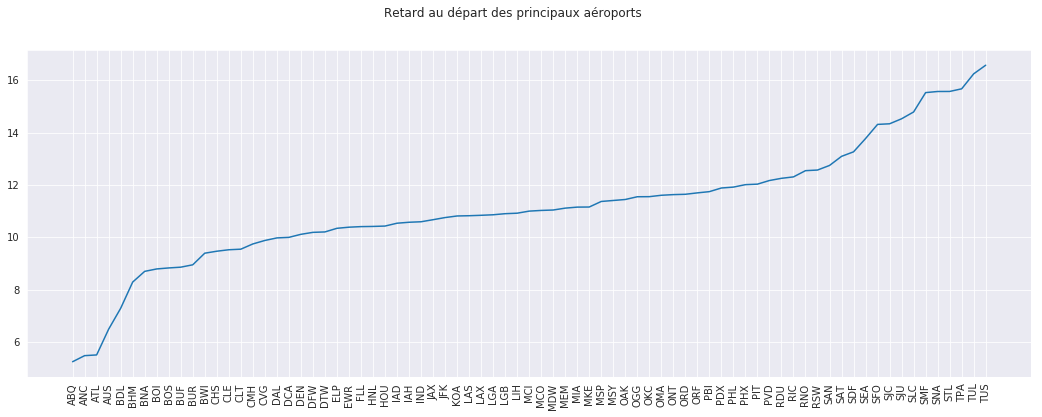

In [0]:
plt.figure(figsize=(18,6))
plt.plot(delay_at_dep['MEAN_DELAY'].sort_values())
locs, labels = plt.xticks()
plt.xticks(locs, labels=delay_at_dep.index, rotation=90)
plt.suptitle('Retard au départ des principaux aéroports')
plt.show()

In [0]:
delay_at_arr = df[['DEST', 'DEP_DELAY', 'ARR_DELAY']]
delay_at_arr['DELAY_AT_ARR'] = delay_at_arr['ARR_DELAY'] - delay_at_arr['DEP_DELAY']
delay_at_arr['DELAY_AT_ARR'] = delay_at_arr['DELAY_AT_ARR'].clip(lower=0)
delay_at_arr = delay_at_arr[['DEST', 'DELAY_AT_ARR']].groupby('DEST').agg(['mean', 'size'])
delay_at_arr.columns = ['MEAN_DELAY', 'FLIGHTS']
delay_at_arr = delay_at_arr[delay_at_arr['FLIGHTS'] > 10000]

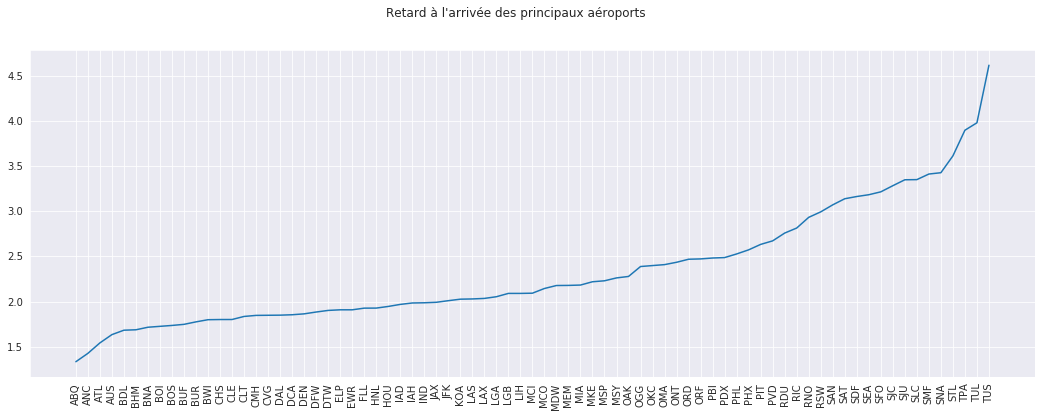

In [0]:
plt.figure(figsize=(18,6))
plt.plot(delay_at_arr['MEAN_DELAY'].sort_values())
locs, labels = plt.xticks()
plt.xticks(locs, labels=delay_at_arr.index, rotation=90)
plt.suptitle("Retard à l'arrivée des principaux aéroports")
plt.show()

In [0]:
taxi_out = df[['ORIGIN', 'TAXI_OUT']].groupby('ORIGIN').agg(['mean', 'size'])
taxi_out.columns = ['MEAN_TAXI_OUT', 'SIZE_OUT']

taxi_in = df[['DEST', 'TAXI_IN']].groupby('DEST').agg(['mean', 'size'])
taxi_in.columns = ['MEAN_TAXI_IN', 'SIZE_IN']

taxi = pd.concat((taxi_out, taxi_in), axis=1)

taxi['SIZE'] = taxi['SIZE_OUT'].fillna(0) + taxi['SIZE_IN'].fillna(0)
taxi.drop(columns=['SIZE_OUT', 'SIZE_IN'], inplace=True)

taxi.head()

MEAN_TAXI_OUT  MEAN_TAXI_IN     SIZE
ABE      13.866090      4.434531   4930.0
ABI      14.481013      5.797468    322.0
ABQ      11.723545      5.408123  37972.0
ABR      16.613079      4.573370   1486.0
ABY      12.411100      3.432405   1949.0

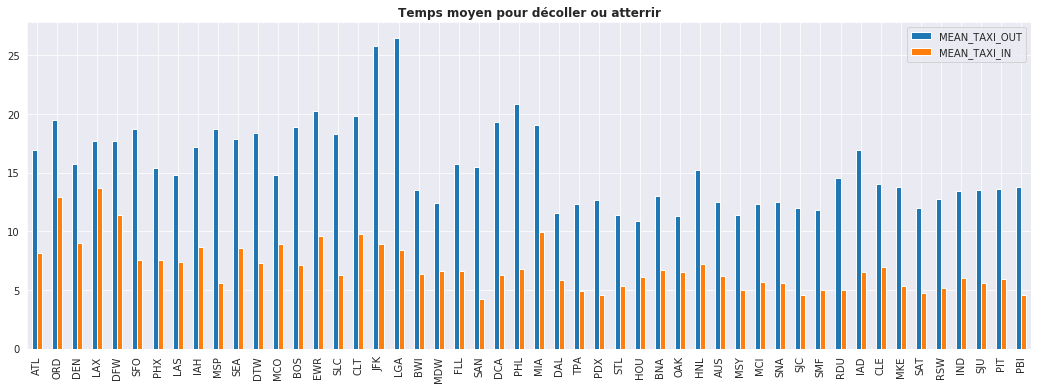

In [0]:
fig, ax = plt.subplots(figsize=(18,6))
taxi.nlargest(50, 'SIZE').drop(columns=['SIZE']).plot.bar(ax=ax)
plt.title('Temps moyen pour décoller ou atterrir', weight='bold')
plt.show()

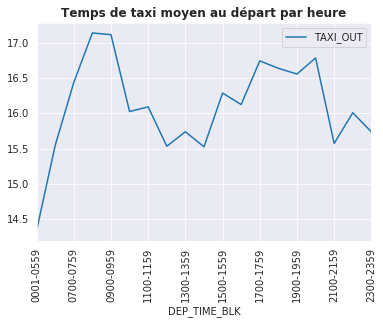

In [0]:
df[['DEP_TIME_BLK', 'TAXI_OUT']].groupby('DEP_TIME_BLK').mean().plot()
plt.xticks(rotation=90)
plt.title('Temps de taxi moyen au départ par heure', weight='bold')
plt.show()

##Analyse des liaisons

###Liaisons les plus fréquentes

In [0]:
n_routes = df.groupby(['ORIGIN', 'DEST']).FLIGHTS.sum()
n_routes.nlargest(9)

ORIGIN  DEST
LAX     SFO     16586.0
SFO     LAX     16187.0
LAX     JFK     12249.0
JFK     LAX     11816.0
LAX     LAS     11133.0
LAS     LAX     11011.0
SEA     LAX      9932.0
LAX     SEA      9799.0
ORD     LGA      9202.0
Name: FLIGHTS, dtype: float64

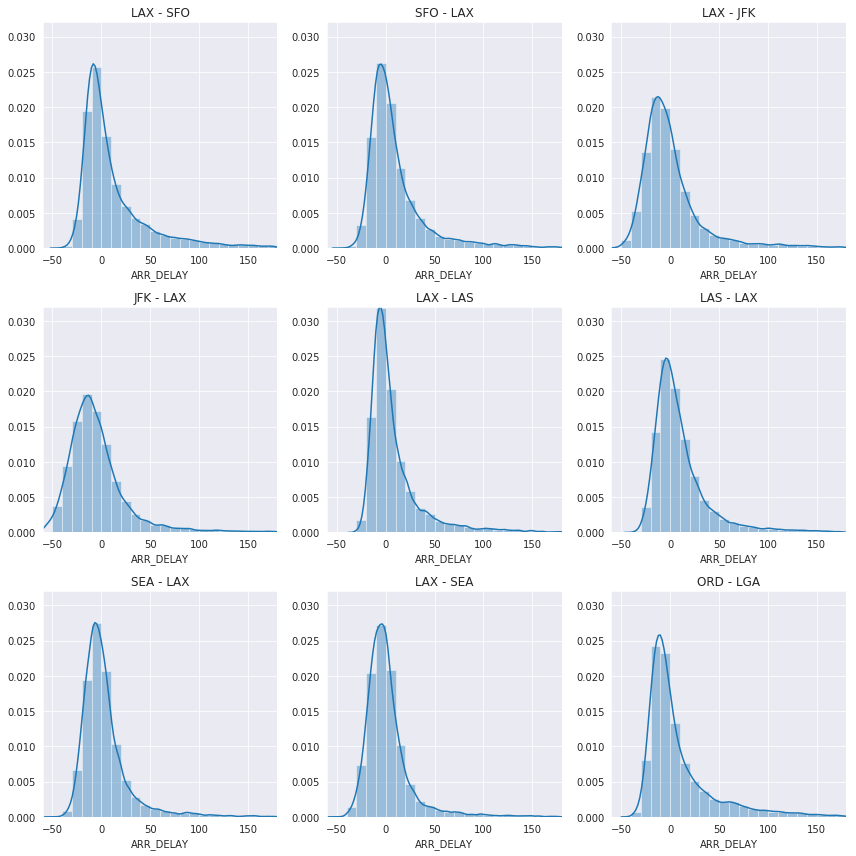

In [0]:
routes = n_routes.nlargest(9).index.get_values()
fig, ax = plt.subplots(3, 3, figsize=(12,12))
bins = np.linspace(-50, 180, 24)

for i, (origin, dest) in enumerate(routes):
    axe = ax.flat[i]
    tmp = df[(df.ORIGIN==origin) & (df.DEST==dest)]
    sns.distplot(tmp.ARR_DELAY.dropna(), bins=bins, ax=axe)
    axe.set_title(f"{origin} - {dest}")
    axe.set_xlim([-60, 180])
    axe.set_ylim([0, 0.032])
    
plt.tight_layout()


(-60, 180)

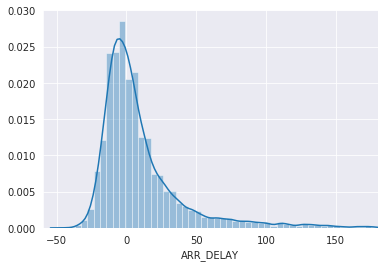

In [0]:
SFOLAX = df[(df['ORIGIN']=='SFO') & (df['DEST']=='LAX')]
sns.distplot(SFOLAX.ARR_DELAY.dropna())
plt.xlim(left=-60, right=180)

In [0]:
SFOLAX.CARRIER.unique()

[AA, DL, OO, UA, VX, WN]
Categories (6, object): [AA, DL, OO, UA, VX, WN]

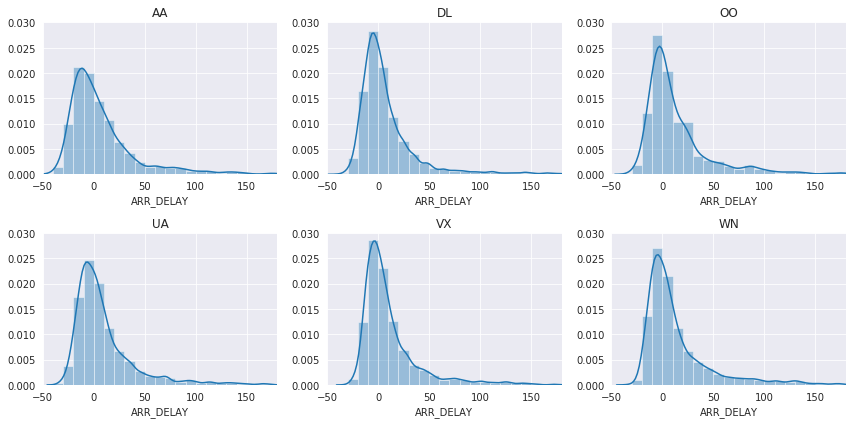

In [0]:
fig, ax = plt.subplots(2, 3, figsize=(12,6))
bins = np.linspace(-50, 180, 24)

for i, carrier in enumerate(SFOLAX.CARRIER.unique()):
    axe = ax.flat[i]
    tmp = SFOLAX[SFOLAX.CARRIER==carrier]
    sns.distplot(tmp.ARR_DELAY.dropna(), bins=bins, ax=axe)
    axe.set_title(carrier)
    axe.set_xlim([-50, 180])
    axe.set_ylim([0, 0.03])
    
plt.tight_layout()

In [0]:
SFOLAX.groupby('CARRIER', observed=True).ARR_DELAY.agg(['size', 'mean', 'std', 'skew', pd.DataFrame.kurt])

size       mean        std      skew       kurt
CARRIER                                                 
AA       2056  11.220696  45.644263  5.234285  61.792569
DL       3991  12.898891  41.977038  3.994266  24.903896
OO        863  16.800472  39.617188  2.775053  10.092028
UA       4209  12.596689  37.568410  3.187925  16.299278
VX       3454  14.583822  36.553022  2.984533  12.752281
WN       3248  18.349410  43.316757  2.738186   9.755474

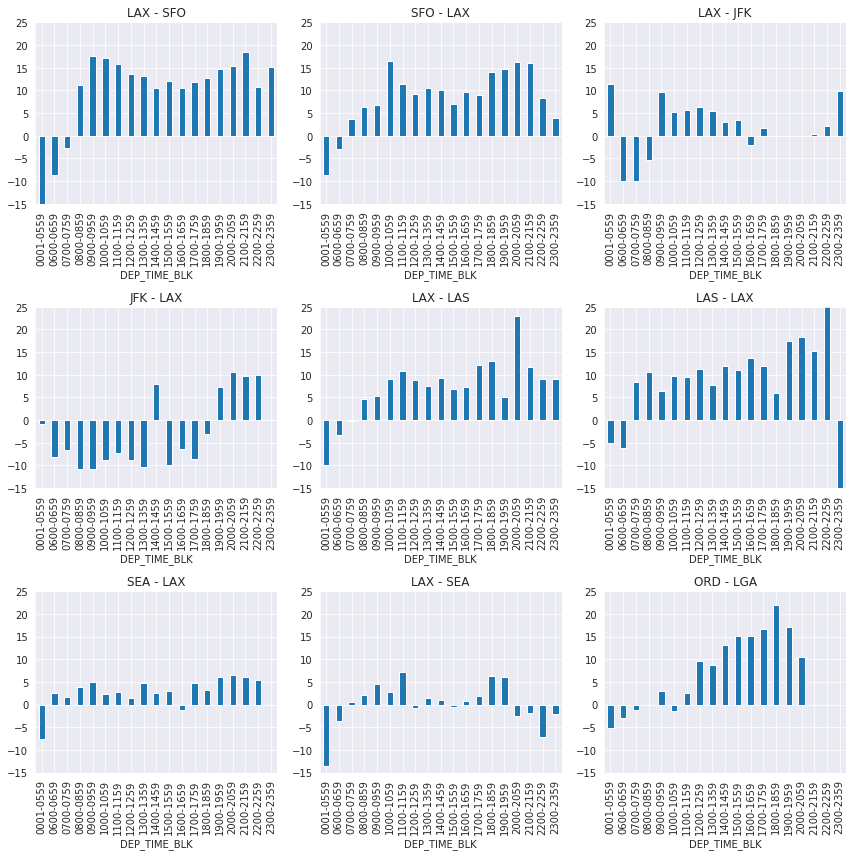

In [0]:
routes = n_routes.nlargest(9).index.get_values()
fig, ax = plt.subplots(3, 3, figsize=(12,12))
bins = np.linspace(-50, 180, 24)

for i, (origin, dest) in enumerate(routes):
    axe = ax.flat[i]
    tmp = df[(df.ORIGIN==origin) & (df.DEST==dest)]
    tmp.groupby('DEP_TIME_BLK').ARR_DELAY.mean().plot.bar(ax=axe)
    axe.set_title(f"{origin} - {dest}")
    axe.set_ylim([-15, 25])
    
plt.tight_layout()

Les liaisons sont toutes différentes les unes des autres. Même si les distributions semblent similaires, elles interagissent différemment suivant d'autres variables discriminantes, comme l'heure de départ par exemple.

###Distance et temps de parcours

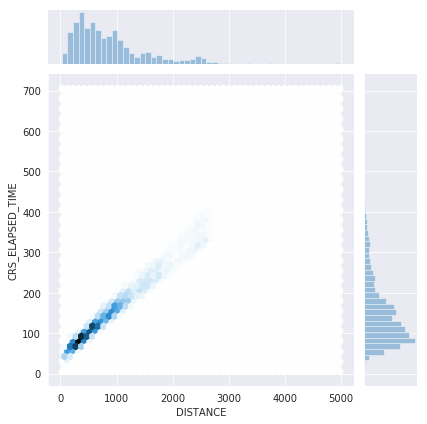

In [6]:
sns.jointplot(x='DISTANCE', y='CRS_ELAPSED_TIME', data=df, kind='hex')

In [0]:
df[['CRS_ELAPSED_TIME', 'DISTANCE']].corr()

CRS_ELAPSED_TIME  DISTANCE
CRS_ELAPSED_TIME          1.000000  0.984518
DISTANCE                  0.984518  1.000000

Forte corrélation entre le temps de vol prévu et la distance.

In [7]:
df[['DISTANCE', 'ARR_DELAY']].corr()

DISTANCE  ARR_DELAY
DISTANCE   1.000000  -0.015238
ARR_DELAY -0.015238   1.000000

Corrélation faible mais négative entre la distance et les retards : un avion en retard a la possibilité de se rattraper en volant un peu plus vite. Plus le trajet est long, plus il peut rattraper du temps.

In [0]:
median_elapsed_no_delay = df[df.ARR_DELAY_NEW==0].groupby(['ORIGIN', 'DEST']).CRS_ELAPSED_TIME.median()
median_elapsed_no_delay.name = 'MEDIAN_TIME'
median_elapsed_no_delay.head()

ORIGIN  DEST
ABE     ATL     133.0
        DTW     106.0
        ORD     135.0
ABI     DFW      61.0
ABQ     ATL     183.0
Name: MEDIAN_TIME, dtype: float64

In [0]:
median_route_duration = df.groupby(['ORIGIN', 'DEST']).ACTUAL_ELAPSED_TIME.transform(np.median)
median_route_duration.head()

0    178.0
1    294.0
2    256.0
3    215.0
4    108.0
Name: ACTUAL_ELAPSED_TIME, dtype: float64

In [0]:
pd.concat((df['ARR_DELAY'], df['CRS_ELAPSED_TIME'] - median_route_duration), axis=1).corr()

ARR_DELAY         0
ARR_DELAY   1.000000 -0.112639
0          -0.112639  1.000000

La différence par rapport au temps de vol habituel sur un trajet est corrélée au retard de manière négative. Plus une compagnie prévoit un temps de trajet supérieur à celui habituellement constaté, plus elle a de la marge pour absorber un éventuel retard.

##Analyse des types de délai



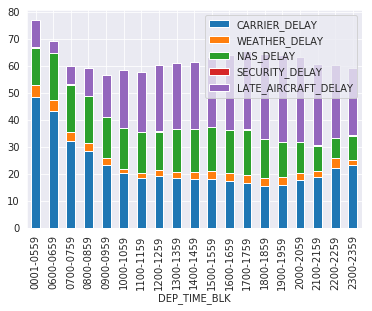

In [74]:
df[['DEP_TIME_BLK', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
    'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']].groupby('DEP_TIME_BLK').mean().plot(kind='bar', stacked=True)

La somme des moyennes des délais ne correspond à la moyenne du délai quand il est nul ou positif.

In [0]:
tmp = df.query('ARR_DELAY_NEW == 0')
tmp[['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']].count()

CARRIER_DELAY          0
WEATHER_DELAY          0
NAS_DELAY              0
SECURITY_DELAY         0
LATE_AIRCRAFT_DELAY    0
dtype: int64

Pas de valeurs non nulles sur les colonnes 'DELAY' lorsqu'il n'y a pas de retard à l'arrivée => fillna par 0.

In [0]:
delay_cols = ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']

for col in delay_cols:
    idx = df[(~df['ARR_DELAY_NEW'].isna()) & (df[col].isna())].index
    df.loc[idx, col] = 0

In [77]:
sum_delays = df[delay_cols].fillna(0).sum(axis=1)
(sum_delays == df['ARR_DELAY_NEW']).mean()

0.8222400994468924

La somme des délais par catégorie n'est pas toujours égale au délai annoncé. On complète par un délai inconnu.

In [0]:
df['UNKNOWN_DELAY'] = np.NaN
df.loc[df[df['ARR_DELAY_NEW'] <= 0].index, 'UNKNOWN_DELAY'] = 0

idx = df[df['ARR_DELAY_NEW'] > 0].index

sum_delays = df.loc[idx, delay_cols].sum(axis=1)
arr_del = df.loc[idx, 'ARR_DELAY_NEW']
df.loc[idx, 'UNKNOWN_DELAY'] = arr_del - sum_delays

delay_cols = ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'UNKNOWN_DELAY']

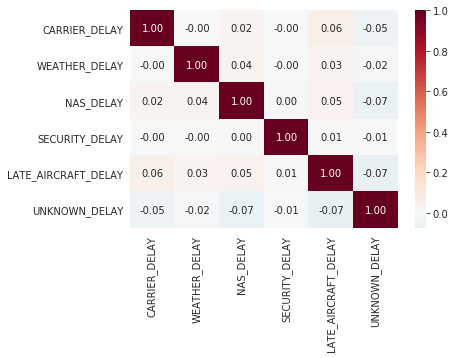

In [79]:
sns.heatmap(df[delay_cols].corr(), center=0, cmap='RdBu_r', annot=True, fmt='.2f')

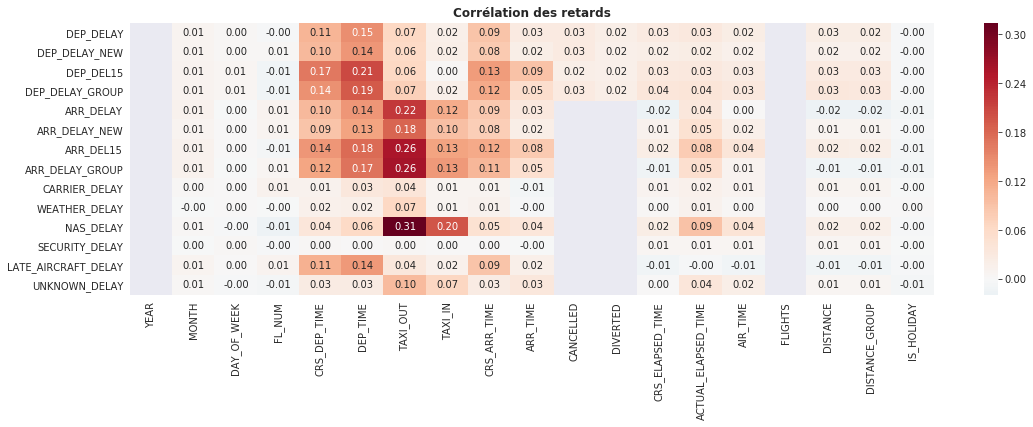

In [84]:
cols = ['DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP',
        'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP',
        'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 
        'LATE_AIRCRAFT_DELAY', 'UNKNOWN_DELAY']

plt.figure(figsize=(18,5))
sns.heatmap(df.corr().loc[cols, :].drop(columns=cols), center=0, cmap='RdBu_r', annot=True, fmt='.2f')
plt.title("Corrélation des retards", weight='bold')
plt.show()

Les délais "NAS" sont corrélées au temps passé sur la piste avant le décollage(TAXI_OUT) ou après l'atterrissage (TAXI_IN). Les avions sont cloués au sol quelque temps avant de pouvoir décoller.

Paradoxallement, le temps de vol (AIR_TIME) ne dépend pas de la météo, on peut penser que les avions attendent avant de décoller si la météo n'est pas favorable.

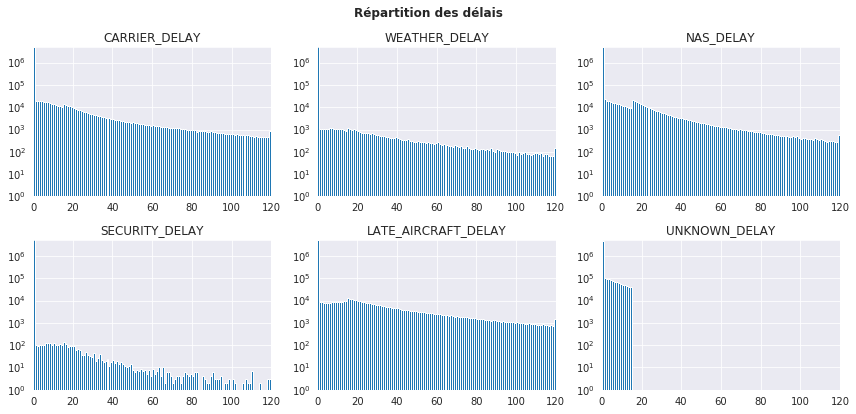

In [0]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

for i, col in enumerate(delay_cols):
    ax.flat[i].set_xlim([0, 120])
    ax.flat[i].set_yscale('log')
    ax.flat[i].set_ylim([1, 5e6])
    ax.flat[i].hist(df[col], bins=range(121))
    ax.flat[i].set_title(col)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Répartition des délais", weight='bold')
plt.show()

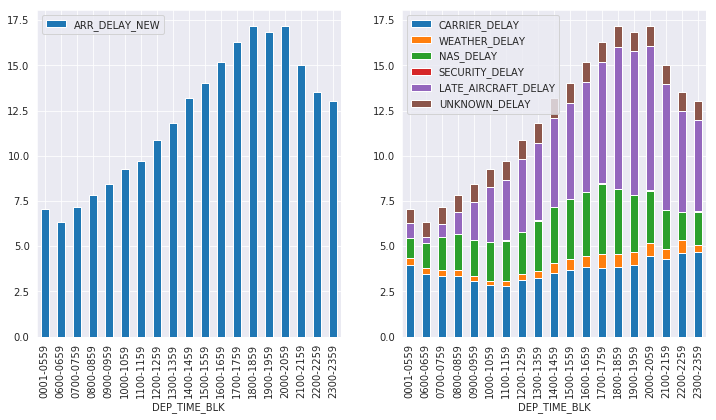

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
df[['ARR_DELAY_NEW', 'DEP_TIME_BLK']].groupby('DEP_TIME_BLK').mean().plot(kind='bar', ax=ax[0])
df[delay_cols + ['DEP_TIME_BLK']].groupby('DEP_TIME_BLK').mean().plot(kind='bar', stacked=True, ax=ax[1])

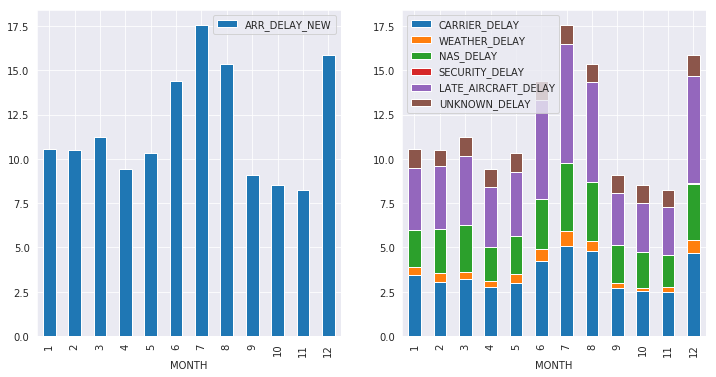

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
df[['ARR_DELAY_NEW', 'MONTH']].groupby('MONTH').mean().plot(kind='bar', ax=ax[0])
df[delay_cols + ['MONTH']].groupby('MONTH').mean().plot(kind='bar', stacked=True, ax=ax[1])

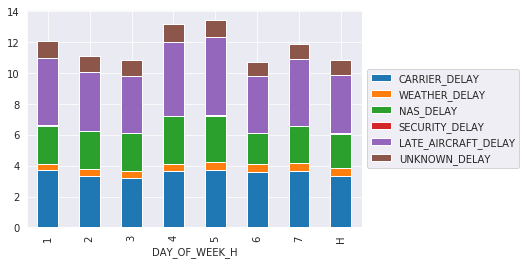

In [0]:
df[delay_cols + ['DAY_OF_WEEK_H']].groupby('DAY_OF_WEEK_H').mean().plot(kind='bar', stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [85]:
pivoted = df[['DEP_TIME_BLK', 'ARR_DELAY_GROUP', 'FLIGHTS']].groupby(['DEP_TIME_BLK', 'ARR_DELAY_GROUP']).sum().unstack()
pivoted.columns = pivoted.columns.droplevel()
pivoted.head()

ARR_DELAY_GROUP     -2.0      -1.0      0.0   ...   10.0   11.0    12.0
DEP_TIME_BLK                                  ...                      
0001-0559         41497.0   74732.0  22388.0  ...  162.0  135.0  1273.0
0600-0659        102737.0  187589.0  61693.0  ...  377.0  321.0  2659.0
0700-0759         95454.0  176148.0  67149.0  ...  455.0  375.0  2273.0
0800-0859         88392.0  168520.0  64600.0  ...  498.0  389.0  2318.0
0900-0959         75116.0  157555.0  64979.0  ...  553.0  410.0  2112.0

[5 rows x 15 columns]

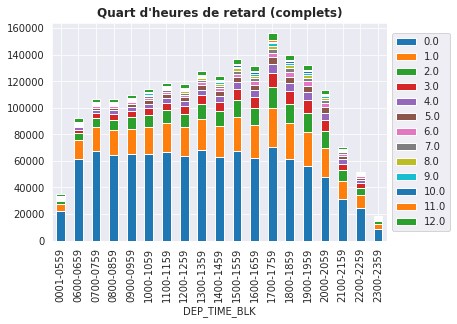

In [86]:
pivoted.iloc[:,2:].plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Quart d'heures de retard (complets)", weight='bold')
plt.show()

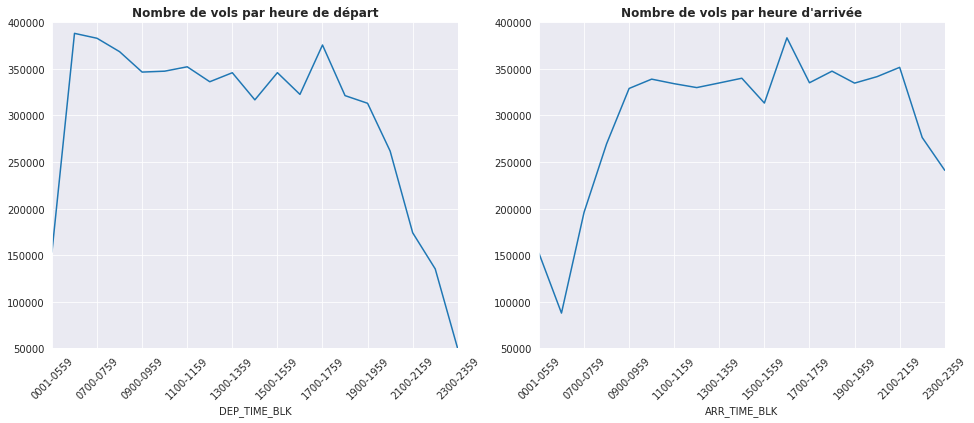

In [103]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

df.groupby('DEP_TIME_BLK').FLIGHTS.sum().plot(ax=ax[0])
ax[0].set_title('Nombre de vols par heure de départ', weight='bold')
ax[0].set_ylim(bottom=50000, top=400000)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)

df.groupby('ARR_TIME_BLK').FLIGHTS.sum().plot(ax=ax[1])
ax[1].set_title("Nombre de vols par heure d'arrivée", weight='bold')
ax[1].set_ylim(bottom=50000, top=400000)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)

plt.show()

##Utilisation des avions

In [88]:
aircraft_use = df.groupby(['CARRIER', 'TAIL_NUM', 'FL_DATE']).FLIGHTS.sum().unstack().fillna(0)
aircraft_use.head()

FL_DATE           2016-01-01  2016-01-02  ...  2016-12-30  2016-12-31
CARRIER TAIL_NUM                          ...                        
AA      N001AA           3.0         0.0  ...         0.0         1.0
        N002AA           0.0         0.0  ...         1.0         3.0
        N003AA           4.0         3.0  ...         0.0         0.0
        N004AA           0.0         0.0  ...         4.0         0.0
        N005AA           3.0         1.0  ...         1.0         3.0

[5 rows x 366 columns]

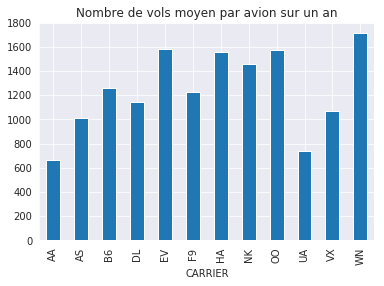

In [90]:
annual_plane_use = aircraft_use.groupby('CARRIER').sum().sum(axis=1) / aircraft_use.groupby('CARRIER').size()
annual_plane_use.plot.bar()
plt.title("Nombre de vols moyen par avion sur un an")
plt.show()

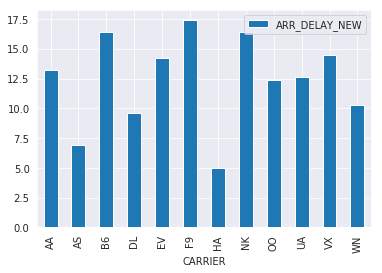

In [0]:
df[['CARRIER', 'ARR_DELAY_NEW']].groupby('CARRIER').mean().plot.bar()

Pas directement lié aux retards.

###Parcours de chaque avion

Objectif : calculer le temps qu'un avion est resté au sol avant de repartir. L'hypothèse est que plus ce temps est court, plus il y a de chance que les retards des vols précédents impactent les vols futurs.

In [0]:
tail_carrier = df.groupby(['TAIL_NUM', 'CARRIER']).size()
index_tails = list(tail_carrier.index.get_level_values(0))
print(f"Avions utilisés par plusieurs compagnies : {set([x for x in index_tails if index_tails.count(x) > 1])}")

Avions utilisés par plusieurs compagnies : {'nan'}


In [0]:
plane_routes = df[['TAIL_NUM', 'FL_DATE', 'ORIGIN', 'DEST', 
                   'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 
                   'DEP_TIME', 'ARR_TIME', 'ACTUAL_ELAPSED_TIME',
                   'DEP_DELAY']]

plane_routes.head()

TAIL_NUM     FL_DATE ORIGIN  ... ARR_TIME  ACTUAL_ELAPSED_TIME  DEP_DELAY
0   N920AT  2016-10-03    JAN  ...   2004.0                 85.0       -6.0
1   N3771K  2016-10-03    DTW  ...   1019.0                176.0       -2.0
2   N3771K  2016-10-03    FLL  ...   1345.0                154.0       -9.0
3   N963DL  2016-10-03    PHL  ...    757.0                122.0       -5.0
4   N342NB  2016-10-03    SLC  ...   2339.0                150.0       -5.0

[5 rows x 11 columns]

In [0]:
timezones = dict(airports_coords[['IATA', 'TZ_DATABASE']].values)

plane_routes['ORIGIN_TZ'] = plane_routes['ORIGIN'].map(timezones)
plane_routes['DEST_TZ'] = plane_routes['DEST'].map(timezones)

In [0]:
plane_routes.head()

TAIL_NUM     FL_DATE ORIGIN  ... DEP_DELAY         ORIGIN_TZ           DEST_TZ
0   N920AT  2016-10-03    JAN  ...      -6.0   America/Chicago  America/New_York
1   N3771K  2016-10-03    DTW  ...      -2.0  America/New_York  America/New_York
2   N3771K  2016-10-03    FLL  ...      -9.0  America/New_York  America/New_York
3   N963DL  2016-10-03    PHL  ...      -5.0  America/New_York  America/New_York
4   N342NB  2016-10-03    SLC  ...      -5.0    America/Denver   America/Chicago

[5 rows x 13 columns]

In [0]:
def str_to_date(date, hour_min):
    return date + 'T' + str(int(hour_min/100)).zfill(2) + ':' + str(int(hour_min % 100)).zfill(2) + ':00'

vect_str_to_date = np.vectorize(str_to_date)

In [0]:
timezones = plane_routes.DEST_TZ.unique()
len(timezones)

13

Comme les informations de départ (date et heure) sont locales, il faut passer par le temps universel pour uniformiser l'heure au départ et à l'arrivée.

In [0]:
plane_routes['LOCAL_CRS_DEP_TIME'] = vect_str_to_date(plane_routes.FL_DATE, plane_routes.CRS_DEP_TIME)
plane_routes['LOCAL_CRS_DEP_TIME'] = pd.to_datetime(plane_routes['LOCAL_CRS_DEP_TIME'], infer_datetime_format=True, errors='coerce')

for tz in timezones:
    index = plane_routes[plane_routes.ORIGIN_TZ == tz].index
    plane_routes.loc[index, 'LOCAL_CRS_DEP_TIME'] = plane_routes.loc[index, 'LOCAL_CRS_DEP_TIME'].dt.tz_localize(tz=tz, ambiguous='NaT', nonexistent='NaT')

plane_routes['UTC_CRS_DEP_TIME'] = pd.to_datetime(plane_routes.LOCAL_CRS_DEP_TIME, utc=True)
plane_routes['UTC_CRS_ARR_TIME'] = plane_routes['UTC_CRS_DEP_TIME'] + pd.to_timedelta(plane_routes['CRS_ELAPSED_TIME'], unit='m')

plane_routes['UTC_DEP_TIME'] = plane_routes['UTC_CRS_DEP_TIME'] + pd.to_timedelta(plane_routes['DEP_DELAY'], unit='m')
plane_routes['UTC_ARR_TIME'] = plane_routes['UTC_DEP_TIME'] + pd.to_timedelta(plane_routes['ACTUAL_ELAPSED_TIME'], unit='m')

In [0]:
plane_routes[plane_routes['UTC_DEP_TIME'].isna()].shape[0]

63551

In [0]:
plane_routes.sort_values(['TAIL_NUM', 'UTC_CRS_DEP_TIME'], inplace=True)

valid_shift_index = plane_routes[
    (plane_routes['ORIGIN']==plane_routes['DEST'].shift())
    & (plane_routes['TAIL_NUM']==plane_routes['TAIL_NUM'].shift())
].index

plane_routes['CRS_PARK_TIME'] = np.NaN
plane_routes.loc[valid_shift_index, 'CRS_PARK_TIME'] = \
    (plane_routes.loc[valid_shift_index, 'UTC_CRS_DEP_TIME'] - plane_routes.shift().loc[valid_shift_index, 'UTC_CRS_ARR_TIME']) \
    / np.timedelta64(1, 'm')


plane_routes.sort_values(['TAIL_NUM', 'UTC_DEP_TIME'], inplace=True)

valid_shift_index = plane_routes[
    (plane_routes['ORIGIN']==plane_routes['DEST'].shift())
    & (plane_routes['TAIL_NUM']==plane_routes['TAIL_NUM'].shift())
    & (~plane_routes['UTC_DEP_TIME'].isna())
    & (~plane_routes['UTC_ARR_TIME'].shift().isna())
].index

plane_routes['ACTUAL_PARK_TIME'] = np.NaN
plane_routes.loc[valid_shift_index, 'ACTUAL_PARK_TIME'] = \
    (plane_routes.loc[valid_shift_index, 'UTC_DEP_TIME'] - plane_routes.shift().loc[valid_shift_index, 'UTC_ARR_TIME']) \
    / np.timedelta64(1, 'm')


In [0]:
plane_routes.head()

TAIL_NUM     FL_DATE  ... CRS_PARK_TIME ACTUAL_PARK_TIME
5071692    7819A  2016-01-02  ...           NaN              NaN
5135845    7819A  2016-01-02  ...          55.0             59.0
5069812    7819A  2016-01-02  ...          40.0             32.0
5135846    7819A  2016-01-02  ...          35.0             54.0
5135568    7819A  2016-01-02  ...          25.0             44.0

[5 rows x 20 columns]

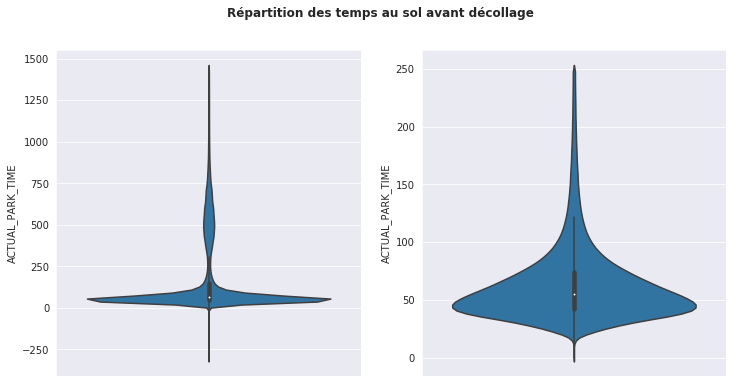

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.violinplot(y='ACTUAL_PARK_TIME', data=plane_routes[plane_routes['ACTUAL_PARK_TIME'] <= 24*60], ax=ax[0])
sns.violinplot(y='ACTUAL_PARK_TIME', data=plane_routes[plane_routes['ACTUAL_PARK_TIME'].between(0, 250)], ax=ax[1])
fig.suptitle('Répartition des temps au sol avant décollage', weight='bold')
plt.show()

Les avions ne restent souvent que 50 min au sol avant de repartir. Il y a tout de même une coupure plus longue durant la nuit qui permet de réinitialiser les retards accumulés.

In [0]:
plane_routes.ACTUAL_PARK_TIME.describe([.01, .1, .25, .5, .75, .9, .99])

count    5.375767e+06
mean     2.427038e+02
std      1.185365e+03
min     -3.010000e+02
1%       2.300000e+01
10%      3.600000e+01
25%      4.600000e+01
50%      6.500000e+01
75%      1.790000e+02
90%      6.020000e+02
99%      1.996000e+03
max      4.049930e+05
Name: ACTUAL_PARK_TIME, dtype: float64

####Exemple du parcours d'un avion :

In [0]:
index = plane_routes.reset_index()[plane_routes.reset_index().ACTUAL_PARK_TIME <= 0].index
index = sorted(list(index) + [i - 1 for i in index])
print(len(index), index[:10])

592 [64722, 64723, 120057, 120058, 205417, 205418, 233425, 233426, 236333, 236334]


In [0]:
plane_routes.iloc[index[:20]]

TAIL_NUM     FL_DATE  ... CRS_PARK_TIME ACTUAL_PARK_TIME
1253014   N11206  2016-08-31  ...         600.0            607.0
1253419   N11206  2016-08-31  ...         -20.0             -8.0
5476167   N12221  2016-12-26  ...           NaN             54.0
5478459   N12221  2016-12-26  ...           NaN           -296.0
5008867   N138DL  2016-01-29  ...           NaN              NaN
5024295   N138DL  2016-01-29  ...        -173.0           -224.0
2806326   N1402A  2016-05-12  ...         100.0            120.0
2806374   N1402A  2016-05-12  ...        -177.0           -158.0
5444250   N140SY  2016-12-16  ...        -135.0             56.0
5441283   N140SY  2016-12-16  ...           NaN           -189.0
2041656   N14231  2016-09-20  ...         412.0            418.0
2039718   N14231  2016-09-20  ...         -34.0            -22.0
1273261   N14249  2016-08-17  ...         604.0            590.0
1274227   N14249  2016-08-17  ...         -26.0             -2.0
1359287   N16234  2016-08-08  ...         356.0            372.0
1359988   N16234  2016-08-08  ...        -135.0           -122.0
1287550   N17752  2016-08-11  ...           NaN              NaN
1281991   N17752  2016-08-11  ...        -137.0           -124.0
4964490   N194DN  2016-01-08  ...         105.0            157.0
4968463   N194DN  2016-01-09  ...         -60.0            -21.0

[20 rows x 20 columns]

In [0]:
plane_routes['CRS_PARK_TIME'].le(0).sum()

44655

Certains vols sont prévus sans pause où avec une pause négative. En fait, l'appareil n'est probablement attribué qu'à la dernière minute, ce qui rend cette donnée difficilement inexploitable.

In [0]:
plane_routes['ACTUAL_PARK_TIME'].le(0).sum()

296

En revanche, on a un problème sur environ 300 vols où le départ s'est efectué avant l'atterrissage. Cela est tout de même négligeable sur les 5M+ de lignes.

In [0]:
df = df.join(plane_routes[['CRS_PARK_TIME', 'ACTUAL_PARK_TIME']])

In [0]:
df[['ACTUAL_PARK_TIME', 'CRS_PARK_TIME', 'ARR_DELAY_NEW']].corr()

ACTUAL_PARK_TIME  CRS_PARK_TIME  ARR_DELAY_NEW
ACTUAL_PARK_TIME          1.000000       0.998228       0.015197
CRS_PARK_TIME             0.998228       1.000000       0.000474
ARR_DELAY_NEW             0.015197       0.000474       1.000000

Faible impact sur les retards.

##Retard médian par jour et par aéroport

In [9]:
top_airports = pd.concat((df.groupby(['ORIGIN']).FLIGHTS.sum(), df.groupby(['DEST']).FLIGHTS.sum()), axis=1)
top_airports = top_airports[top_airports.sum(axis=1) >= 2 * 30 * 366]
top_airports = top_airports.index
top_airports.shape

(76,)

In [15]:
origin_airport_delay = df.groupby(['ORIGIN', 'FL_DATE']).ARR_DELAY.median().unstack().loc[top_airports, :]
dest_airport_delay = df.groupby(['DEST', 'FL_DATE']).ARR_DELAY.median().unstack().loc[top_airports, :]
dest_airport_delay.head()

FL_DATE  2016-01-01  2016-01-02  2016-01-03  ...  2016-12-29  2016-12-30  2016-12-31
DEST                                         ...                                    
ABQ            -4.0       -10.0        -1.0  ...        -1.0        -3.5        -2.0
ANC           -23.0       -14.0        -7.0  ...        -3.0         5.0         4.0
ATL           -10.0       -11.0        -7.0  ...        -8.0       -12.0       -12.0
AUS            -3.5        -5.0        -6.0  ...        -1.0        -8.0        -7.0
BDL           -12.0        -3.0        -7.0  ...         0.0         1.0        -8.0

[5 rows x 366 columns]

In [16]:
origin_airport_delay.max(axis='columns').head()

ORIGIN
ABQ     88.5
ANC     11.0
ATL    144.0
AUS     36.0
BDL     64.5
dtype: float64

Certains jours, le retard médian dépasse 1h dans un aéroport ! Il s'agit d'une anomalie qui peut avoir plusieurs origines, notamment :
*   le temps
*   problème électrique (coupure massive de courant)
*   incendie
*   grève

Ces évènements ne se reproduisent pas d'une année sur l'autre ou du moins, pas à la même date. Il faudra les identifier et les supprimer de la modélisation.


In [19]:
origin_cancellation_rate = df.groupby(['ORIGIN', 'FL_DATE']).CANCELLED.mean().unstack()
dest_cancellation_rate = df.groupby(['DEST', 'FL_DATE']).CANCELLED.mean().unstack()
print(f"Taux d'annulation au départ de Denver le 23 mars 2016 : {origin_cancellation_rate.loc['DEN', '2016-03-23'] * 100:.2f}%")

Taux d'annulation au départ de Denver le 23 mars 2016 : 94.87%


In [0]:
IATA = 'DEN'
hovertext = 'size: ' + median_airport_delay.loc[IATA, 'size'].astype(str)

configure_plotly_browser_state()

data = []

trace = dict(
    type='scatter',
    mode='lines+markers',
    x=origin_airport_delay.loc[IATA, 'median'].index,
    y=origin_airport_delay.loc[IATA, 'median'].values,
    hovertext=hovertext,
    name="Origin",
    marker=dict(
        size=3,
    )
)

data.append(trace)

trace = dict(
    type='scatter',
    mode='lines+markers',
    x=dest_airport_delay.loc[IATA, 'median'].index,
    y=dest_airport_delay.loc[IATA, 'median'].values,
    hovertext=hovertext,
    name="Dest",
    marker=dict(
        size=3,
    )
)

data.append(trace)

trace = dict(
    type='bar',
    x=origin_cancellation_rate.loc[IATA].index,
    y=100 * origin_cancellation_rate.loc[IATA].values,
    hovertext=hovertext,
    name="Origin<br>taux<br>d'annulation",
)

data.append(trace)

trace = dict(
    type='bar',
    x=dest_cancellation_rate.loc[IATA].index,
    y= -100 * dest_cancellation_rate.loc[IATA].values,
    hovertext=hovertext,
    name="Dest<br>taux<br>d'annulation",
)

data.append(trace)

layout = dict(
    title=f"Retard médian au départ de {IATA} et taux d'annulation",
    hovermode='closest',
)
fig = dict(data=data, layout=layout)
iplot(fig)

Il y a eu 4 jours en 2016 où les taux d'annulation ont été très élevés.

[Denver Blizzard: Snow totals for March 23, 2016](https://www.thedenverchannel.com/news/local-news/denver-blizzard-snow-totals-for-march-23-2016)

Il peut y avoir le même type de phénomène pour une compagnie aérienne : 

[A single computer outage can now wreak havoc on big companies -- and the customers they serve.](https://www.washingtonpost.com/news/the-switch/wp/2016/08/08/what-you-need-to-know-about-the-massive-delta-computer-outage/?noredirect=on)